In [1]:
import numpy as np
import pandas as pd
import polars as pl
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
os.chdir('..')
os.chdir('src')
from env import BlackjackEnv


In [2]:
def parse_strategy_csv(file_path):
    try:
        # Read the CSV file
        df = pl.read_csv(file_path)
        
        # Initialize the basic strategy dictionary
        strategy = {}
        
        # Process the dataframe into a dictionary
        for row in df.iter_rows(named=True):
            # Parse the state from string format like '(12, 10, 0)'
            # Extract the state values
            state_str = row['State'].strip('()').split(', ')

            # state_str = row['State'].strip('[]').split()
            player_sum = int(state_str[0])
            dealer_card = int(state_str[1])
            usable_ace = int(state_str[2])
            
            # Create the state key
            state_key = (player_sum, dealer_card, usable_ace)
            
            # Get the action values
            stand_value = row['Action 0 (Stand)']
            hit_value = row['Action 1 (Hit)']
            # Check if the column for double action exists
            if 'Action 2 (Double)' in row:
                double_value = row['Action 2 (Double)']
            else:
                # If not present, set double value to None or some default
                double_value = None
            
            # Store the action values in a dictionary
            strategy[state_key] = {
                0: stand_value,  # Stand
                1: hit_value,    # Hit
                2: double_value   # Double
            }
            
        return strategy
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return {}

In [3]:
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1],
    "actions": ["stand", "hit", "double"],
    "num_players": 1
}
# Create environment with 6 decks (standard casino configuration)
env = BlackjackEnv(config=config)


### Initialization of Q table

In [4]:
os.chdir('..')
os.chdir('strategies')
# read the reference Q-table from the CSV file
Q_ref = parse_strategy_csv('dq_hit_stand_strat.csv')


In [5]:
# Generate relevant states - focusing on decision points that matter
states = []
# For hard totals (no usable ace), only track 12-21
# Below 12, the optimal play is always hit
for player_sum in range(5, 22):
    for dealer_card in range(2, 12):
        states.append((player_sum, dealer_card, 0))  # Hard total

# For soft totals (with usable ace), track 12-21
# Soft totals below 12 are impossible (A+1 = 12)
for player_sum in range(12, 22):
    for dealer_card in range(2, 12):
        states.append((player_sum, dealer_card, 1))  # Soft total

In [6]:
# Initialize Q-tables as dictionaries
q_table = {}
q_table2 = {}  # Second Q-table for double Q-learning

# Initialize Q-values based on reference values
for state in states:
    player_sum, dealer_card, ace = state
    
    # Initialize with values from reference Q-table if available
    if state in Q_ref:
        q_table[state] = {
            0: Q_ref[state][0],  # Stand
            1: Q_ref[state][1],  # Hit
        }
    else:
        # Default initialization
        if player_sum >= 20:
            q_table[state] = {0: 0.5, 1: -0.1}  # Prefer stand for high sums
        elif player_sum < 12:
            q_table[state] = {0: -0.1, 1: 0.5}  # Prefer hit for low sums
        else:
            q_table[state] = {0: 0.0, 1: 0.0}  # Neutral for middle sums
    
    # Initialize the double action
    if player_sum >= 17:
        q_table[state][2] = q_table[state][1] - 0.3 if not ace else q_table[state][1] - 0.1
    elif player_sum < 12:
        if player_sum >= 9:
            q_table[state][2] = 0.5  # Initialize double to neutral for certain hands
        else:
            q_table[state][2] = min(q_table[state][0], q_table[state][1]) - 0.3
    else:
        # Initialize double for other states slightly lower than best action
        q_table[state][2] = min(q_table[state][0], q_table[state][1]) - 0.3

# Copy the initial Q-table to the second table
q_table2 = copy.deepcopy(q_table)

In [7]:
# Track state-action visit counts for adaptive learning rates
visit_counts = {}
for state in states:
    for action in [0, 1, 2]:  # Stand, Hit, Double
        visit_counts[(state, action)] = 0

### Hyperparameters

In [8]:
# Improved hyperparameters
initial_lr = 0.1             # Learning rate
lr_decay_rate = 0.00005      # Gentler decay rate
gamma = 0.95                 # Higher discount factor - long-term rewards matter mor
initial_epsilon = 1.0        # Start with 100% exploration
epsilon_min = 0.01           # Minimum exploration rate
epsilon_decay = 0.99995      # Much slower decay rate

### Helper functions Strategy Q-table

In [9]:

# Modified state representation - focusing on meaningful game states
def get_state_features(full_state):
    # Extract just player sum, dealer card, and usable ace
    player_sum = full_state[0]
    dealer_card = full_state[1]
    usable_ace = full_state[2]
    return (player_sum, dealer_card, usable_ace)


In [10]:
def get_adaptive_lr(state, action, base_lr):
    """Get state-action specific learning rate based on visit count"""
    key = (state, action)
    count = visit_counts.get(key, 0) + 1
    # Decay learning rate based on visit count, but maintain a minimum rate
    return max(base_lr / (1 + 0.005 * count), base_lr * 0.1)

In [11]:
def get_q_values(state_features, q_table=q_table):
    """Get Q-values for a given state"""
    if state_features in q_table:
        return np.array([q_table[state_features][0], q_table[state_features][1], q_table[state_features][2]])
    else:
        # Return default values based on player sum
        player_sum = state_features[0]
        if player_sum < 12:
            return np.array([-0.1, 0.5, 0.0])  # Default to hit for low sums
        elif player_sum >= 20:
            return np.array([0.5, -0.1, 0.0])  # Default to stand for high sums
        else:
            return np.array([0.0, 0.0, 0.0])  # Neutral for middle sums

In [12]:
def update_q_value(state_features, action, reward, next_state_features, lr, q_table=q_table, q_table_target=q_table2):
    """Update Q-value for state-action pair using Double Q-learning"""
    if state_features not in q_table:
        return  # State not in our table
    
    # Current Q-value
    current_q = q_table[state_features][action]
    
    # If next_state_features is None, this is a terminal state
    if next_state_features is None:
        # Terminal state - no future rewards
        new_q = current_q + lr * (reward - current_q)
    else:
        # Get the next state's best action from current Q-table
        next_q_values = get_q_values(next_state_features, q_table)
        best_next_action = np.argmax(next_q_values)
        
        # Get Q-value for best action from target Q-table
        next_q_values_target = get_q_values(next_state_features, q_table_target)
        max_next_q = next_q_values_target[best_next_action]
        
        # Q-learning update formula with future rewards
        new_q = current_q + lr * (reward + gamma * max_next_q - current_q)
    
    # Update the Q-table entry
    q_table[state_features][action] = new_q
    
    # Track visit counts
    visit_counts[(state_features, action)] = visit_counts.get((state_features, action), 0) + 1
    
    return q_table

### Training Q-table

In [13]:
# Training loop with convergence check
print("Starting improved training...")
wins = 0
draws = 0
losses = 0
epsilon = initial_epsilon
lr = initial_lr
money_won = 0
money_lost = 0

# Parameters for convergence
n_episodes = 1000000  # Number of episodes for training
convergence_threshold = 0.001  # Lower threshold for better stability
convergence_check_interval = 10000  # Check for convergence every N episodes
convergence_required_count = 3  # Number of consecutive checks below threshold to confirm convergence
max_episodes = n_episodes  # Maximum episodes as a fallback

# Keep a copy of the previous Q-table for comparison
# previous_q = Q.clone()
previous_q = copy.deepcopy(q_table)
convergence_count = 0
converged = False
episode = 0
#first training phase only for the Q-table with fixed betting strategy
while episode < max_episodes and not converged:

    env.reset()
    bet_index = env.bet_space.sample()  # Sample bet index from the environment
    bet_amount = env.bets[bet_index]  # Sample bet amount from the environment
    # print(env.step(bet_index, action_type="bet"))
    state, reward, done = env.step(bet_index, action_type="bet")  # Place bet
    if done:
        if reward > 0:
            wins += 1
            money_won += reward * bet_amount
        elif reward == 0:
            draws += 1
        else:
            losses += 1
            money_lost += abs(reward) * bet_amount
    # print(bet_amount)
    state_features = get_state_features(state)

    # Training episode
    while not done:
        
        if state_features[0] < 9:
        # Always hit this state as it's not relevant for our training
            next_state, _, _ = env.step(1, action_type="move")
            next_state_features = get_state_features(next_state) if not done else None
            state = next_state
            state_features = next_state_features if next_state is not None else None
            continue
        
        # Epsilon-greedy action selection
        elif np.random.rand() < epsilon:
            if np.random.rand() < 0.3:
                action = 2
            else:
                action = env.move_space.sample()  # Random action
        else:
            q_values1 = get_q_values(state_features, q_table)
            q_values2 = get_q_values(state_features, q_table2)
            q_values = (q_values1 + q_values2)/2
            action = np.argmax(q_values)  # Greedy action
        
        if action == 2:
            bet_amount *= 2  # Double the bet amount

        # Take action
        next_state, reward, done = env.step(action, action_type="move")
        next_state_features = get_state_features(next_state) if not done else None

        # Get adaptive learning rate for this state-action pair
        adaptive_lr = get_adaptive_lr(state_features, action, lr)

        # Randomly decide which Q-table to update (Double Q-learning)
        # print(f"State: {state_features}, Action: {action}, Done: {done}, Reward: {reward}, Next State: {next_state_features}")
        if np.random.rand() < 0.5:
            # print("Updating Q-table 1")
            q_table = update_q_value(state_features, action, reward*bet_amount, next_state_features, adaptive_lr, q_table, q_table2)
        else:
            # print("Updating Q-table 2")
            q_table2 = update_q_value(state_features, action, reward*bet_amount, next_state_features, adaptive_lr, q_table2, q_table)
            
        # Track outcomes
        if done:
            if reward > 0:
                wins += 1
                money_won += reward * bet_amount
            elif reward == 0:
                draws += 1
            else:
                losses += 1
                money_lost += abs(reward) * bet_amount
        
        state = next_state
        state_features = next_state_features if next_state is not None else None
        
        if state_features is None:
            # print(f"Entered break condition with done being {done}")
            break
    
    # Decay epsilon and learning rate
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    lr = initial_lr / (1 + lr_decay_rate * episode)
    
    # Check for convergence periodically
    if episode % convergence_check_interval == 0 and episode > 0:
        # Calculate the maximum absolute difference between current and previous Q-values
        # Compute differences for "Stand" (action 0) and "Hit" (action 1)
        diff_stand = [q_table[state][0] - previous_q[state][0] for state in q_table if state in previous_q]
        diff_hit = [q_table[state][1] - previous_q[state][1] for state in q_table if state in previous_q]
        diff_double = [q_table[state][2] - previous_q[state][2] for state in q_table if state in previous_q]
        
        # Calculate the maximum absolute differences
        max_diff_stand = max(abs(diff) for diff in diff_stand) if diff_stand else 0
        max_diff_hit = max(abs(diff) for diff in diff_hit) if diff_hit else 0
        max_diff_double = max(abs(diff) for diff in diff_double) if diff_double else 0
        max_diff = max(max_diff_stand, max_diff_hit, max_diff_double)
        
        if max_diff < convergence_threshold:
            convergence_count += 1
            print(f"Episode {episode}, max Q-value change: {max_diff:.6f} (convergence count: {convergence_count}/{convergence_required_count})")
            if convergence_count >= convergence_required_count:
                print(f"Converged after {episode} episodes (max Q-value change: {max_diff:.6f})")
                converged = True
        else:
            convergence_count = 0
            print(f"Episode {episode}, max Q-value change: {max_diff:.6f}")
        
        # Store current Q-values for next comparison
        previous_q = copy.deepcopy(q_table)
    
    episode += 1

# Final statistics
total_episodes = episode
print(f"Training complete after {total_episodes} episodes.")
print(f"Win rate: {wins/total_episodes:.4f}")
print(f"Draw rate: {draws/total_episodes:.4f}")
print(f"Loss rate: {losses/total_episodes:.4f}")

Starting improved training...
Episode 10000, max Q-value change: 0.961921
Episode 20000, max Q-value change: 0.621165
Episode 30000, max Q-value change: 0.466078
Episode 40000, max Q-value change: 0.306273
Episode 50000, max Q-value change: 0.283280
Episode 60000, max Q-value change: 0.228981
Episode 70000, max Q-value change: 0.202245
Episode 80000, max Q-value change: 0.123391
Episode 90000, max Q-value change: 0.131334
Episode 100000, max Q-value change: 0.131628
Episode 110000, max Q-value change: 0.130041
Episode 120000, max Q-value change: 0.098366
Episode 130000, max Q-value change: 0.121047
Episode 140000, max Q-value change: 0.075410
Episode 150000, max Q-value change: 0.123709
Episode 160000, max Q-value change: 0.095701
Episode 170000, max Q-value change: 0.049329
Episode 180000, max Q-value change: 0.062702
Episode 190000, max Q-value change: 0.045107
Episode 200000, max Q-value change: 0.037171
Episode 210000, max Q-value change: 0.045810
Episode 220000, max Q-value change

### Testing Q-table win rate

In [14]:

# Evaluate the final policy with more episodes
print("\nFinal policy evaluation...")
eval_wins = 0
eval_draws = 0
eval_loss = 0
money_won = 0
money_lost = 0
eval_episodes = 10000
doubles = 0

for _ in range(eval_episodes):
    env.reset()
    bet_index = env.bet_space.sample()  # Sample bet index from the environment
    bet_amount = env.bets[bet_index]  # Sample bet amount from the environment
    # print(env.step(bet_index, action_type="bet"))
    state, reward, done = env.step(bet_index, action_type="bet")  # Place bet
    if done:
        if reward > 0:
            eval_wins += 1
            money_won += reward * bet_amount
        elif reward == 0:
            eval_draws += 1
        else:
            eval_loss += 1
            money_lost += abs(reward) * bet_amount
    # print(bet_amount)
    state_features = get_state_features(state)

    # Training episode
    while not done:
        # Always choose the best action according to average of both Q-tables
        q_values1 = get_q_values(state_features, q_table)
        q_values2 = get_q_values(state_features, q_table2)
        avg_q_values = (q_values1 + q_values2) / 2
        action = np.argmax(avg_q_values)
        
        if action == 2:
            bet_amount *= 2  # Double the bet amount
            doubles += 1

        next_state, reward, done = env.step(action, action_type="move")
        
        if done and reward > 0:
            eval_wins += 1
            money_won += reward * bet_amount
        elif done and reward == 0:
            eval_draws += 1
        elif done and reward < 0:
            eval_loss += 1
            money_lost += abs(reward) * bet_amount
        else:
            pass
        
        state = next_state
        state_features = get_state_features(state)

        if done:
            break

print(f"Final evaluation complete.")
print(f"Win rate: {eval_wins/eval_episodes:.4f}")
print(f"Draw rate: {eval_draws/eval_episodes:.4f}")
print(f"Loss rate: {eval_loss/eval_episodes:.4f}")
print(f"Money won: {money_won}")
print(f"Money lost: {money_lost}")
print(f"Total doubles: {doubles}")
print(f"Average reward: {(money_won - money_lost)/eval_episodes:.4f}")


Final policy evaluation...
Final evaluation complete.
Win rate: 0.4304
Draw rate: 0.0856
Loss rate: 0.4840
Money won: 4874.0
Money lost: 5051
Total doubles: 628
Average reward: -0.0177


### Benchmarking with basic strategy

In [15]:
os.chdir('..')
os.chdir('strategies')
basic_strat = parse_strategy_csv('basic_strat_doub.csv')

In [16]:
# Evaluate the final policy with more episodes
print("\nFinal policy evaluation...")
bench_wins = 0
bench_draws = 0
bench_loss = 0
money_won = 0
money_lost = 0
bench_episodes = 10000
doubles = 0

for _ in range(bench_episodes):
    env.reset()
    bet_index = env.bet_space.sample()  # Sample bet index from the environment
    bet_amount = env.bets[bet_index]  # Sample bet amount from the environment
    # print(env.step(bet_index, action_type="bet"))
    state, reward, done = env.step(bet_index, action_type="bet")  # Place bet
    if done:
        if reward > 0:
            bench_wins += 1
            money_won += reward * bet_amount
        elif reward == 0:
            bench_draws += 1
        else:
            bench_loss += 1
            money_lost += abs(reward) * bet_amount
    # print(bet_amount)
    state_features = get_state_features(state)

    # Training episode
    while not done:
        # Always choose the best action according to average of both Q-tables
        q_values = get_q_values(state_features, basic_strat)
        action = np.argmax(q_values)
        # if state_features in basic_strat:
        #     action = 0 if basic_strat[state_features][0] > basic_strat[state_features][1] else 1
        # else:
        #     # Default action if state not found in basic strategy (it means we are below 5)
        #     action = 1
        if action == 2:
            bet_amount *= 2
            doubles += 1

        next_state, reward, done = env.step(action, action_type="move")
        
        if done and reward > 0:
            bench_wins += 1
            money_won += reward * bet_amount
        elif done and reward == 0:
            bench_draws += 1
        elif done and reward < 0:
            bench_loss += 1
            money_lost += abs(reward) * bet_amount
        else:
            pass
        
        state = next_state
        state_features = get_state_features(state)

        if done:
            break

print(f"Final evaluation complete.")
print(f"Win rate: {bench_wins/bench_episodes:.4f}")
print(f"Draw rate: {bench_draws/bench_episodes:.4f}")
print(f"Loss rate: {bench_loss/bench_episodes:.4f}")
print(f"Money won: {money_won}")
print(f"Money lost: {money_lost}")
print(f"Total doubles: {doubles}")
print(f"Average reward: {(money_won - money_lost)/bench_episodes:.4f}")


Final policy evaluation...
Final evaluation complete.
Win rate: 0.4338
Draw rate: 0.0897
Loss rate: 0.4765
Money won: 5193.0
Money lost: 5192
Total doubles: 1151
Average reward: 0.0001


### Output creation

In [17]:
# Calculate average Q-values (ensemble approach)
avg_q_table = copy.deepcopy(q_table)
for state in q_table:
    for action in q_table[state]:
        avg_q_table[state][action] = (q_table[state][action] + q_table2[state][action]) / 2
action_map = {0: "Stand", 1: "Hit", 2: "Double"}
# Save the Q-table to a CSV file
avg_q_table_df = pd.DataFrame([
    {
        'State': state,
        'Action 0 (Stand)': actions[0],
        'Action 1 (Hit)': actions[1],
        'Action 2 (Double)': actions[2] if 2 in actions else None,
        'Best Action': action_map[np.argmax([actions[0], actions[1], actions.get(2, float('-inf'))])]
    }
    for state, actions in avg_q_table.items()
])
# avg_q_table_df.to_csv('dq_h_s_dd_strat.csv', index=False)

### Comparison with basic strategy

In [18]:
def visualize_blackjack_policies(basic_strat_file, q_table_df):
    """
    Visualize and compare blackjack policies from two CSV files.
    
    Parameters:
    basic_strat_file (str): Path to the basic strategy CSV file
    q_table_file (str): Path to the Q-table CSV file
    """
    # Read the CSV files
    basic_strat_df = pd.read_csv(basic_strat_file)
    q_table_df = pd.read_csv(q_table_df)

    def extract_state_info(state_str):
        # Extract values from format like "(12, 3, 0)"
        state_str = state_str.strip('()').split(',')
        player_value = int(state_str[0])
        dealer_card = int(state_str[1])
        usable_ace = int(state_str[2])
        return player_value, dealer_card, usable_ace
    
    # Create mapping dictionaries for both dataframes
    basic_policy = {}
    q_policy = {}
    
    # Process basic strategy data
    for _, row in basic_strat_df.iterrows():
        try:
            player_value, dealer_card, usable_ace = extract_state_info(row['State'])
            basic_policy[(player_value, dealer_card, usable_ace)] = row['Best Action']
        except:
            print(f"Couldn't parse state: {row['State']}")
            
    # Process Q-table data
    for _, row in q_table_df.iterrows():
        try:
            player_value, dealer_card, usable_ace = extract_state_info(row['State'])
            q_policy[(player_value, dealer_card, usable_ace)] = row['Best Action']
        except:
            print(f"Couldn't parse state: {row['State']} in double q")
    
    # Prepare data for visualization
    # Define the range of player values and dealer cards
    player_values = sorted(set([k[0] for k in basic_policy.keys()]))
    dealer_cards = sorted(set([k[1] for k in basic_policy.keys()]))
    
    # Create matrices for visualization (one for non-usable ace, one for usable ace)
    # 0 = no usable ace, 1 = usable ace
    basic_matrix_no_ace = np.zeros((len(player_values), len(dealer_cards)), dtype=object)
    basic_matrix_ace = np.zeros((len(player_values), len(dealer_cards)), dtype=object)
    q_matrix_no_ace = np.zeros((len(player_values), len(dealer_cards)), dtype=object)
    q_matrix_ace = np.zeros((len(player_values), len(dealer_cards)), dtype=object)
    
    # Map player values and dealer cards to indices
    player_map = {val: i for i, val in enumerate(player_values)}
    dealer_map = {val: i for i, val in enumerate(dealer_cards)}
    
    # Fill the matrices
    for (player, dealer, ace), action in basic_policy.items():
        if player in player_map and dealer in dealer_map:
            if ace == 0:
                basic_matrix_no_ace[player_map[player], dealer_map[dealer]] = action
            else:
                basic_matrix_ace[player_map[player], dealer_map[dealer]] = action
    
    for (player, dealer, ace), action in q_policy.items():
        if player in player_map and dealer in dealer_map:
            if ace == 0:
                q_matrix_no_ace[player_map[player], dealer_map[dealer]] = action
            else:
                q_matrix_ace[player_map[player], dealer_map[dealer]] = action
    basic_matrix_no_ace = basic_matrix_no_ace[4:,:]
    basic_matrix_ace = basic_matrix_ace[4:,:]
    q_matrix_no_ace = q_matrix_no_ace[4:,:]
    q_matrix_ace = q_matrix_ace[4:,:]
    # Visualization function
    def plot_policy_matrix(matrix, title, ax):
        # Convert 'Hit'/'Stand'/'Double' to numeric for coloring
        numeric_matrix = np.zeros(matrix.shape)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if matrix[i, j] == 'Stand':
                    numeric_matrix[i, j] = 1
                elif matrix[i, j] == 'Hit':
                    numeric_matrix[i, j] = 0
                elif matrix[i, j] == 'Double':
                    numeric_matrix[i, j] = 2
        # Create heatmap
        # sns.color_palette("bright", as_cmap=True)
        sns.heatmap(numeric_matrix, annot=matrix, fmt='', cmap='gist_rainbow', cbar=False, ax=ax,
                    xticklabels=dealer_cards, yticklabels=player_values[4:], linewidths=.5)
        
        # Set title and labels
        ax.set_title(title)
        ax.set_xlabel('Dealer Card')
        ax.set_ylabel('Player Value')
        
        # Set tick labels
        ax.set_xticks(np.arange(len(dealer_cards)) + 0.5)
        ax.set_yticks(np.arange(len(player_values[4:])) + 0.5)
        ax.set_xticklabels(dealer_cards)
        ax.set_yticklabels(player_values[4:])
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    # fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # plot_policy_matrix(basic_matrix_no_ace, "Basic Strategy - No Usable Ace", axes[ 0])
    # plot_policy_matrix(basic_matrix_ace, "Basic Strategy - Usable Ace", axes[1])
    
    plot_policy_matrix(basic_matrix_no_ace, "Basic Strategy - No Usable Ace", axes[0, 0])
    plot_policy_matrix(basic_matrix_ace, "Basic Strategy - Usable Ace", axes[0, 1])
    plot_policy_matrix(q_matrix_no_ace, "Q-Learning Strategy - No Usable Ace", axes[1, 0])
    plot_policy_matrix(q_matrix_ace, "Q-Learning Strategy - Usable Ace", axes[1, 1])
    
    plt.tight_layout()
    # plt.savefig("blackjack_policy_comparison_new.png", dpi=300, bbox_inches='tight')
    plt.show()
    

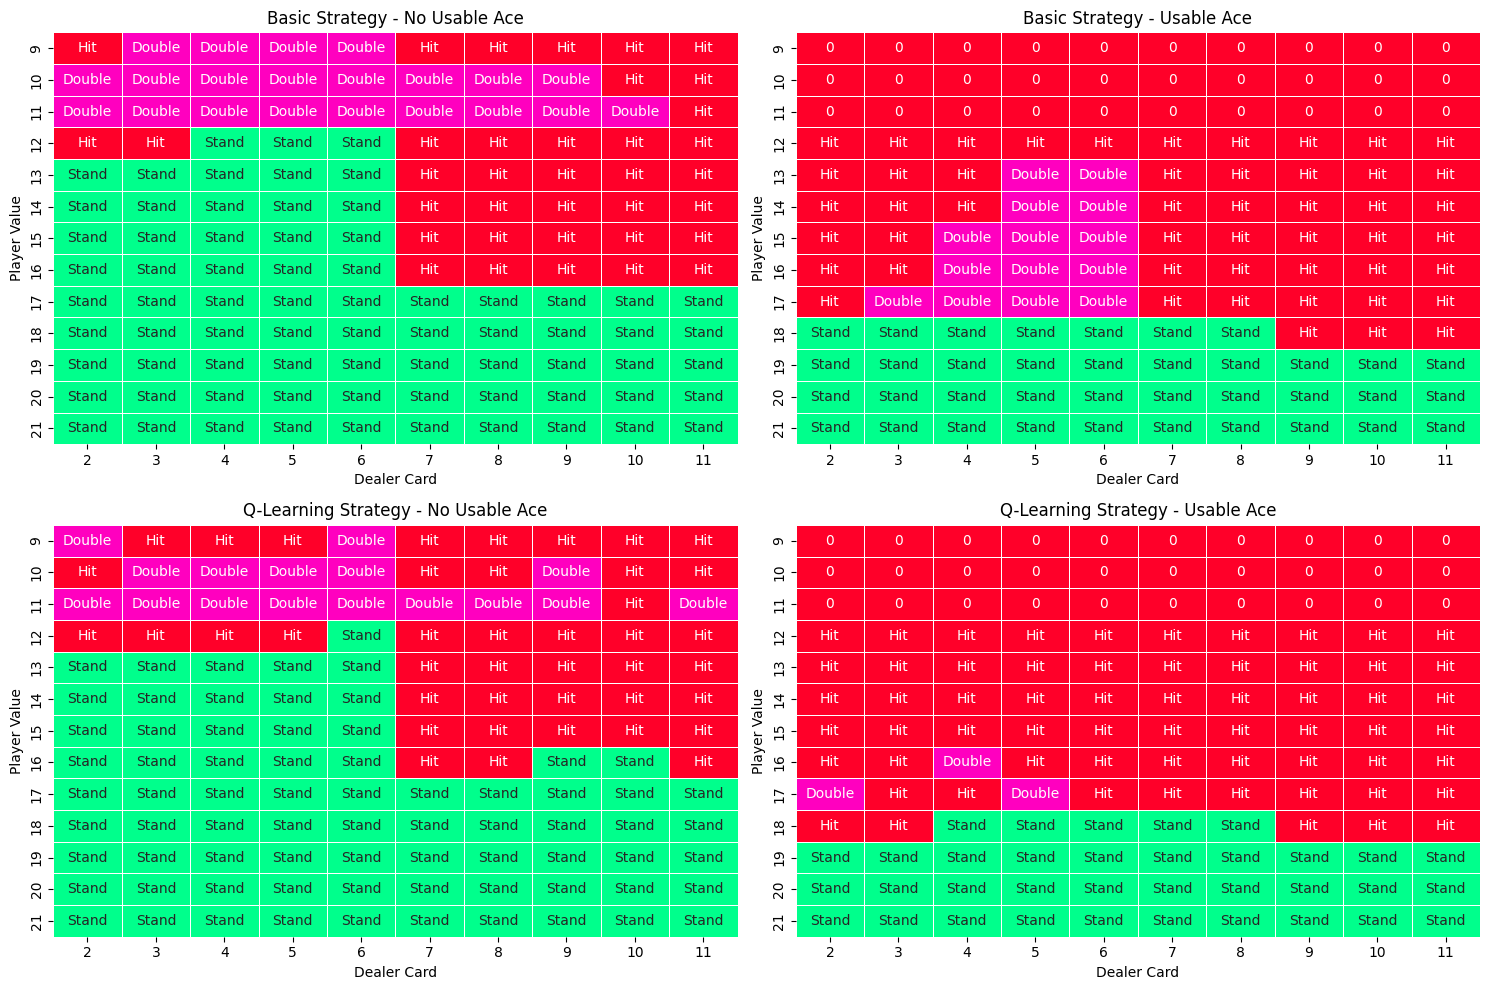

In [19]:
visualize_blackjack_policies("basic_strat_doub.csv", "dq_h_s_dd_strat.csv")